In [1]:
import torch
import os



# GPU 할당 변경하기
GPU_NUM = 4  # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')

torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check



Current cuda device  4


In [2]:
import time
import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

### nomalization 

In [3]:
x_data = np.load('data_label/x_data.npy')
y_data = np.load('data_label/y_data.npy')

xy = torch.empty(1,257,382*2).to('cuda:3')
xy_data = np.concatenate([x_data, y_data], axis=2 )
scaler = StandardScaler()


num = x_data.shape[0]
for idx in range(num):
    scaled_xy = scaler.fit_transform(xy_data[idx,:,:])
    scaled_xy = torch.as_tensor( scaled_xy ).reshape(1,257,382*2).to('cuda:3')
    xy = torch.cat([xy, scaled_xy],axis=0)


scaled_x = xy[1:,:,:382].reshape(2210,1,257,382).to('cuda:3')
scaled_y = xy[1:,:,382:].reshape(2210,1,257,382).to('cuda:3')

scaled_x.shape, scaled_y.shape

(torch.Size([2210, 1, 257, 382]), torch.Size([2210, 1, 257, 382]))

In [4]:

scaled_x.to(device)
scaled_y.to(device)

with torch.cuda.device('cuda:3'):
    torch.cuda.empty_cache()


In [5]:
train_size = 2210
full_dataset = TensorDataset(scaled_x.float(), scaled_y.float())
train_dataset = DataLoader( dataset=full_dataset, batch_size = 20)
                           #shuffle=True, drop_last=True)


### model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F



def conv_trans_block( in_dim, out_dim, act_fn ):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
        # (H-1)*2 -2*1 + 1*(3-1) +1 +1 = 2*H
        nn.BatchNorm2d(out_dim),
        act_fn)
    return model


# (H,W) -> (H/2, W/2)
def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool


def conv_block( in_dim, out_dim, act_fn ):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
        nn.Conv2d(out_dim, out_dim, kernel_size=3,  padding=1),
        nn.BatchNorm2d(out_dim),
        )
    return model


def conv_input( in_dim, out_dim, act_fn ):
    model = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=(3,2), padding=1), # H, W+1
            nn.BatchNorm2d(out_dim),
            act_fn,
            nn.Conv2d(out_dim, out_dim, kernel_size=(2,2),  padding=(0,1)), # H-1, W+1
            nn.BatchNorm2d(out_dim),
            )
    return model


def conv_output( in_dim, out_dim, act_fn ):
    model = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=(3,4), padding=(1,1)), # H, W-1
            nn.BatchNorm2d(out_dim),
            act_fn,
            nn.Conv2d(out_dim, out_dim, kernel_size=(2,4),  padding=(1,1)), # H+1, W-1
            nn.BatchNorm2d(out_dim),
            )
    return model


def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.1)
        

In [7]:
class UnetGenerator(nn.Module):
    def __init__(self, in_dim, out_dim, num_filter):
        super(UnetGenerator, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)
        
        
        self.down_1 = conv_input(self.in_dim, self.num_filter*1, act_fn) #(257,382) -> (1,256,384)
        self.pool_1 = maxpool() #(1,256,384) -> (1,128,192)
        self.down_2 = conv_block(self.num_filter*1, self.num_filter*2, act_fn) 
        self.pool_2 = maxpool() #(1,128,192) -> (2,64,96)
        self.down_3 = conv_block(self.num_filter*2, self.num_filter*4, act_fn)
        self.pool_3 = maxpool() #(2,64,96) -> (4,32,48)
        self.down_4 = conv_block(self.num_filter*4, self.num_filter*8, act_fn)
        self.pool_4 = maxpool() #(4,32,48) -> (8,16,24)
        self.bridge = conv_block(self.num_filter*8, self.num_filter*16, act_fn) #(8,32,48) -> (16,16,24)
        
    
        self.trans_1 = conv_trans_block(self.num_filter*16, self.num_filter*8, act_fn)
        self.up_1 = conv_block(self.num_filter*16, self.num_filter*8, act_fn) #(16,16,24) -> (8,32,48)    
        self.trans_2 = conv_trans_block(self.num_filter*8, self.num_filter*4, act_fn)
        self.up_2 = conv_block(self.num_filter*8, self.num_filter*4, act_fn) #(8,32,48)  -> (4,64,96)
        self.trans_3 = conv_trans_block(self.num_filter*4, self.num_filter*2, act_fn)
        self.up_3 = conv_block(self.num_filter*4, self.num_filter*2, act_fn) #(4,64,96)  -> (2,128,192)
        self.trans_4 = conv_trans_block(self.num_filter*2, self.num_filter*1, act_fn)
        self.up_4 = conv_output(self.num_filter*2, self.num_filter*1, act_fn) #(2,128,192) -> (1,257,382)
        
        self.out = nn.Sequential(
                nn.Conv2d(self.num_filter, self.out_dim, kernel_size=3, padding=1),
                nn.Tanh()
        )
        
        
    def forward(self, input):

        #(N,1,257,382)
        down_1 = self.down_1(input)  #(N,1*C,256,384)
        pool_1 = self.pool_1(down_1) #(N,1*C,128,192)        
        down_2 = self.down_2(pool_1) 
        pool_2 = self.pool_2(down_2) #(N,2*C,64,96)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3) #(N,4*C,32,48)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4) #(N,8*C,16,24)

        bridge = self.bridge(pool_4) #(N,16*C,16,24)

        trans_1  = self.trans_1(bridge) #(N,8*C,32,48)
        concat_1 = torch.cat([trans_1, down_4], dim=1) #(N,16*C,32,48)
        up_1     = self.up_1(concat_1) #(N,8*C,32,48)
        trans_2  = self.trans_2(up_1)  #(N,4*C,64,96)
        concat_2 = torch.cat([trans_2, down_3], dim=1) #(N,8*C,64,96)
        up_2     = self.up_2(concat_2) #(N,4*C,64,96)
        trans_3  = self.trans_3(up_2)  #(N,2*C,128,192)
        concat_3 = torch.cat([trans_3, down_2], dim=1)  #(N,4*C,128,192)
        up_3     = self.up_3(concat_3) #(N,2*C,128,192)
        trans_4  = self.trans_4(up_3)  #(N,C,256,384)
        concat_4 = torch.cat([trans_4, down_1], dim=1)  #(N,2*C,256,384)
        up_4     = self.up_4(concat_4) #(N,C,257,382)

        out = self.out(up_4)

        return out


In [8]:
from collections import OrderedDict

in_dim=1
out_dim=1
num_filter=64
epoch=50
lr=0.00001

checkpoint = torch.load('Unet2')
state_dict =checkpoint['model_state_dict']

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove 'module.' of dataparallel
    new_state_dict[name]=v

    
model = UnetGenerator(in_dim=in_dim, out_dim=out_dim, num_filter=num_filter).to(device)
model.load_state_dict(new_state_dict)
model.apply(init_weights)
model = nn.DataParallel(model, device_ids=[4,5,1], output_device=4)
#model = model.cuda()

loss_func = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [9]:


model.train()
for i in range(epoch):
    s = time.time()
    for (data,label) in train_dataset:
        (data, label) = (data.to(device), label.to(device))
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = loss_func(output,label)
        loss.backward()
        
        optimizer.step()
    
    if i%10 == 9 or i==0:
        print('epoch:' + str(i+1) + ',  Loss: {:.3f},   time: {:.3f}sec'.format( loss.item(), time.time()-s ))

epoch:1,  Loss: 0.561,   time: 44.468sec
epoch:10,  Loss: 0.280,   time: 39.671sec
epoch:20,  Loss: 0.266,   time: 39.599sec
epoch:30,  Loss: 0.244,   time: 39.653sec
epoch:40,  Loss: 0.277,   time: 39.652sec
epoch:50,  Loss: 0.249,   time: 39.651sec


In [10]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'Unet2')

### result

In [11]:
idx=10

<IPython.core.display.Javascript object>


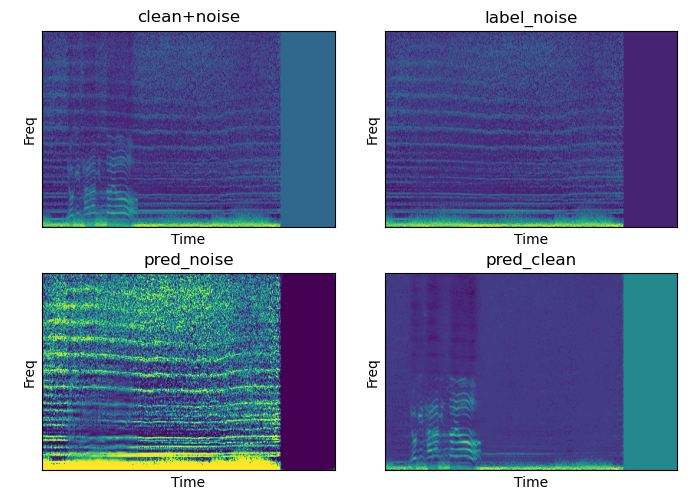

In [12]:
%matplotlib notebook

label_  = label[idx].to('cpu').detach().numpy().reshape(257,382)
output_ = output[idx].to('cpu').detach().numpy().reshape(257,382)
input_  = data[idx].to('cpu').detach().numpy().reshape(257,382)

pred_clean = input_ - output_


x = [ input_, label_, output_, pred_clean]
title=['clean+noise', 'label_noise', 'pred_noise', 'pred_clean']

fig = plt.figure(figsize=(7,5))
row, col = 2,2

for i,mag in enumerate(x):
    ax = fig.add_subplot(row, col, i+1)
    im = ax.imshow(mag, origin='lower')
    ax.set_title(title[i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Freq')
    ax.set_xticks([]), ax.set_yticks([])
    #fig.colorbar(im, shrink=0.7)

plt.tight_layout()
plt.savefig('pred_noise.png')
plt.show()